# Run inference with tflite model for landmark detection

In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Image original shape:  (550, 550, 3)
[{'name': 'input_12', 'index': 0, 'shape': array([  1, 256, 256,   3]), 'shape_signature': array([ -1, 256, 256,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 473, 'shape': array([   1,    1,    1, 1434]), 'shape_signature': array([  -1,    1,    1, 1434]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'Identity_1', 'index': 472, 'shape': array([1, 1, 1, 1]), 'shape_signature': array([-1,  1,  1,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'qu

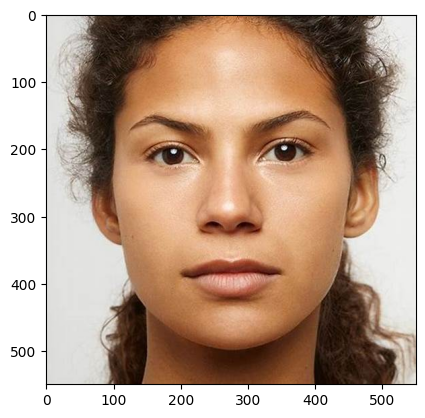

In [3]:
img = cv2.imread('face2.jpg')
print('Image original shape: ', img.shape)
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)
plt.plot()


interpreter = tf.lite.Interpreter('face_landmarks_detector.tflite')
interpreter.allocate_tensors()

#Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

# Test landmark inference


In [19]:
image_size = 256
input_img = cv2.resize(rgb_img, [image_size,image_size])
input_normalized = input_img/127.5-1
input_blob = np.zeros((1,image_size, image_size,3),
                                dtype=np.float32)
input_blob[0] = input_normalized
input_blob.shape

(1, 256, 256, 3)

In [20]:
interpreter.set_tensor(input_details[0]['index'], input_blob)
interpreter.invoke()
#Get output
output_data = interpreter.get_tensor(output_details[0]['index'])
output_data.shape

(1, 1, 1, 1434)

In [21]:
landmark = np.reshape(output_data, [-1,3])

In [12]:
landmark.shape

(478, 3)

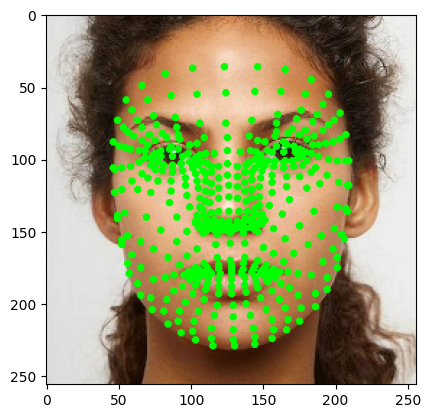

In [23]:
result = input_img.copy()
for i in range(len(landmark)):
    x,y,_ = landmark[i]
    cv2.circle(result, (int(x), int(y)), 1, (0, 255, 0), 2)
plt.imshow(result)
plt.show()

In [64]:
def landmark_detection(frame, interpreter, bbox=[205,105,310,230]): #ratio = input_image_size /2 = 192/2
    def estimate_trans_bbox(face, input_size, s=2.0):
        wc = int(face[2]/ 2 + face[0])
        hc = int(face[3]/2 + face[1])
        scale = input_size / (max(face[2], face[3]) * s)
        M =np.array([
            [scale, 0, input_size / 2 - wc * scale],
            [0, scale, input_size / 2 - hc * scale],
        ])
        return M

    M = estimate_trans_bbox(bbox, 256)
    img = frame.copy()
    image_size = 256

    rimg = cv2.warpAffine(img, M, (image_size,image_size), borderValue=0.0)
    input_img = cv2.resize(frame.copy(), [image_size,image_size])

    input_img = cv2.cvtColor(rimg, cv2.COLOR_BGR2RGB)
    
    input_img = input_img/127.5 -1

    input_blob = np.zeros((1,image_size, image_size,3),
                                dtype=np.float32)
    input_blob[0] = input_img

  # #Set input tensor
    interpreter.set_tensor(input_details[0]['index'], input_blob)
    interpreter.invoke()
  # #Get output
    output_data = interpreter.get_tensor(output_details[0]['index'])

  # #Visualize landmark
    landmark = np.reshape(output_data.copy(),[-1,3])

    IM = cv2.invertAffineTransform(M)
    result =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for x,y,_ in landmark:
        x, y = np.dot(IM, [x,y,1])
        cv2.circle(result, (int(x), int(y)), 1, (0, 255, 0), 2)

    return result


# Landmark pipeline

## Test haarcascades detect face

In [29]:
def detect_face(frame):
    # Converting image to grayscale
    gray_img = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2GRAY)

    # Loading the required haar-cascade xml classifier file
    haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')
  
    # Applying the face detection method on the grayscale image
    faces_rect = haar_cascade.detectMultiScale(gray_img, 1.3, 9)

    return faces_rect

def draw_bbox(boxes, image):
    # Iterating through rectangles of detected faces
    for (x, y, w, h) in boxes:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
    return image

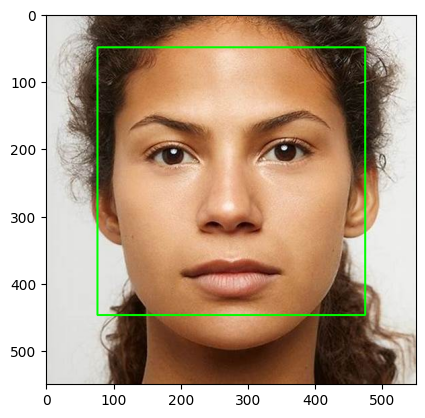

In [66]:
#Test detect face
frame = cv2.imread('face2.jpg')

bbox = detect_face(frame)

face = draw_bbox(bbox, frame)
rgb_img = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)

plt.imshow(rgb_img)
plt.show()

## Land mark detection

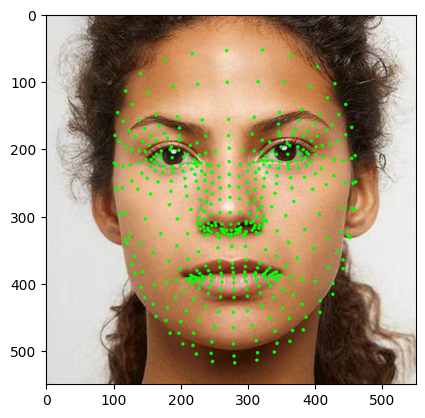

In [65]:
#Test pipeline
frame = cv2.imread('face2.jpg')

# s = time.time()
bbox = detect_face(frame)
for (x, y, w, h) in bbox:
    frame = landmark_detection(frame, interpreter, bbox=[x,y,w,h])
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
# e = time.time()

# print("Detect landmark in: ",(e-s))
rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.imshow(rgb_frame)
plt.show()

In [52]:
vid = cv2.VideoCapture(0)

print("Starting video: ")
# s_video = time.time()
while(vid.isOpened()):
    
    # Capture the video frame
    # by frame
    ret, frame = vid.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    # Display the resulting frame
#     s = time.time()
    bbox = detect_face(frame)
    for (x, y, w, h) in bbox:
        #Above is the original 
        frame = landmark_detection(frame, interpreter, bbox=[x,y,w,h])
        frame = draw_bbox(bbox, frame)
        
    cv2.imshow('frame', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

vid.release()
# # Destroy all the windows
cv2.destroyAllWindows()

Starting video: 
